# Test PEtab + roadrunner + pyPESTO + pocoMC

## Import libraries and load PEtab problem

In [1]:
import numpy as np
import petab
import pocomc as pc
import pypesto.objective
import pypesto.optimize as optimize
import pypesto.objective.roadrunner as pypesto_rr
import pypesto.sample as sample
import pypesto.visualize as visualize
import pypesto.profile as profile
import pypesto.store as store
import pypesto.logging as log
from IPython.display import Markdown, display
import pypesto.history as history
from pprint import pprint
import matplotlib.pyplot as plt

np.random.seed(123)

model_name = "Michaelis_Menten"

In [2]:
petab_yaml = f"./{model_name}/{model_name}.yaml"

petab_problem = petab.Problem.from_yaml(petab_yaml)
importer = pypesto_rr.PetabImporterRR(petab_problem)
problem = importer.create_problem()


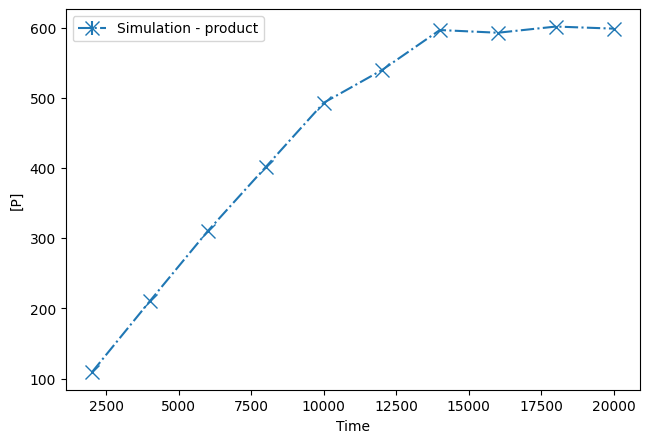

In [3]:
petab.visualize.plot_problem(petab_problem);
plt.gcf().set_size_inches(6, 4)

     time,      [S1],     [S2],       [S3],    [S4]
 [[     0,       600,        6,          0,       0],
  [  2500,   461.256,  0.73873,    5.26127, 133.483],
  [  5000,   332.695, 0.977601,     5.0224, 262.283],
  [ 10000,   107.554,  2.25358,    3.74642,   488.7],
  [ 15000,   5.97573,  5.49014,   0.509857, 593.514],
  [ 17500,  0.757098,  5.93015,  0.0698452, 599.173],
  [ 20000, 0.0903424,  5.99158, 0.00842199, 599.901]]



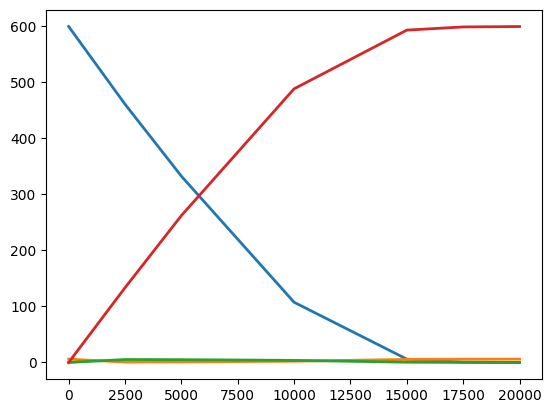

In [4]:
# direct simulation of the model using roadrunner
sim_res = problem.objective.roadrunner_instance.simulate(
    times=[0, 2500, 5000, 10000, 15000, 17500, 20000]
)
pprint(sim_res)
problem.objective.roadrunner_instance.plot();

In [5]:
ret = problem.objective(
    petab_problem.get_x_nominal(fixed=False,scaled=True),
    mode="mode_fun",
    return_dict=True,
)
pprint(ret)

{'fval': 177.58442025403264,
 'llh': -177.58442025403264,
 'simulation_results': {'simCondition':      time, product
 [[     0,       0],
  [  2000, 107.087],
  [  4000, 211.486],
  [  6000,  311.84],
  [  8000, 405.779],
  [ 10000,   488.7],
  [ 12000,  551.96],
  [ 14000, 586.184],
  [ 16000, 597.104],
  [ 18000, 599.458],
  [ 20000, 599.901]]
}}


In [6]:
import scipy
print(scipy.optimize.show_options("minimize", method="Nelder-Mead"))

Minimization of scalar function of one or more variables using the
Nelder-Mead algorithm.

Options
-------
disp : bool
    Set to True to print convergence messages.
maxiter, maxfev : int
    Maximum allowed number of iterations and function evaluations.
    Will default to ``N*200``, where ``N`` is the number of
    variables, if neither `maxiter` or `maxfev` is set. If both
    `maxiter` and `maxfev` are set, minimization will stop at the
    first reached.
return_all : bool, optional
    Set to True to return a list of the best solution at each of the
    iterations.
initial_simplex : array_like of shape (N + 1, N)
    Initial simplex. If given, overrides `x0`.
    ``initial_simplex[j,:]`` should contain the coordinates of
    the jth vertex of the ``N+1`` vertices in the simplex, where
    ``N`` is the dimension.
xatol : float, optional
    Absolute error in xopt between iterations that is acceptable for
    convergence.
fatol : number, optional
    Absolute error in func(xopt) bet

In [7]:
solver_options = pypesto_rr.SolverOptions(
    relative_tolerance = 5e-10,
    absolute_tolerance = 1e-10,
)
engine = pypesto.engine.MultiProcessEngine()
problem.objective.solver_options = solver_options

Engine will use up to 8 processes (= CPU count).


In [8]:

print(problem.objective.history)
history_options = history.HistoryOptions(trace_record=True)
hist_opts = history.HistoryOptions.assert_instance(history_options)
problem.objective.__setattr__("history", problem.objective.create_history("ch1", x_names=problem.objective.x_names, options=hist_opts))
print(problem.objective.history)

## OPTIONAL: Run local optimization using Nelder-Mead

In [9]:
"""
optimizer = optimize.ScipyOptimizer(method="Nelder-Mead", options={"maxiter":10000})

result = optimize.minimize(
    problem=problem,
    optimizer=optimizer,
    n_starts=100,  # usually a value >= 100 should be used
    engine=engine
)
display(Markdown(result.summary()))
"""


'\noptimizer = optimize.ScipyOptimizer(method="Nelder-Mead", options={"maxiter":10000})\n\nresult = optimize.minimize(\n    problem=problem,\n    optimizer=optimizer,\n    n_starts=100,  # usually a value >= 100 should be used\n    engine=engine\n)\ndisplay(Markdown(result.summary()))\n'

In [10]:
"""
sampler = sample.MetropolisSampler()
sampler.initialize(problem=problem, x0=np.array([-1,1,0]))
print(sampler.neglogpost.history)

history_options = history.HistoryOptions(trace_record=True)
hist_opts = history.HistoryOptions.assert_instance(history_options)
sampler.neglogpost.__setattr__("history", problem.objective.create_history("ch1", x_names=problem.objective.x_names, options=hist_opts))
print(sampler.neglogpost.history)"""

'\nsampler = sample.MetropolisSampler()\nsampler.initialize(problem=problem, x0=np.array([-1,1,0]))\nprint(sampler.neglogpost.history)\n\nhistory_options = history.HistoryOptions(trace_record=True)\nhist_opts = history.HistoryOptions.assert_instance(history_options)\nsampler.neglogpost.__setattr__("history", problem.objective.create_history("ch1", x_names=problem.objective.x_names, options=hist_opts))\nprint(sampler.neglogpost.history)'

## Run PT-MCMC

In [11]:
sampler = sample.AdaptiveParallelTemperingSampler(
    internal_sampler=sample.AdaptiveMetropolisSampler(), n_chains=4
)
sampler.initialize(problem=problem, x0=np.array([-1,1,0]))
print(sampler.__dict__.keys())

for internal_sampler in sampler.samplers:
	history_options = history.HistoryOptions(trace_record=True)
	hist_opts = history.HistoryOptions.assert_instance(history_options)
	internal_sampler.neglogpost.__setattr__("history", problem.objective.create_history("ch1", x_names=problem.objective.x_names, options=hist_opts))


Initializing betas with "near-exponential decay".


dict_keys(['options', 'betas0', 'betas', 'temper_lpost', 'samplers'])


In [12]:
%%time
sampler.sample(n_samples=10000);

#sample.effective_sample_size(result);
#sample.auto_correlation(result);

100%|██████████| 10000/10000 [00:30<00:00, 323.04it/s]

CPU times: user 30.9 s, sys: 105 ms, total: 31 s
Wall time: 31 s


In [13]:
for internal_sampler in sampler.samplers:
	print(internal_sampler.neglogpost.history.__dict__["_n_fval"])

7125
6435
7111
5364


In [ ]:
print(sampler.neglogpost.history.__dict__.keys())
print(sampler.neglogpost.history.__dict__["_n_fval"])

## Translate pyPESTO problem into functions used by pocoMC

In [17]:
lower_bnds = problem.lb
upper_bnds = problem.ub
neglogprior = sampler.samplers[0].neglogprior
"""
def log_prior(x):
    bools = [
        (low <= i <= high)
        for i, low, high in zip(x, lower_bnds, upper_bnds)
    ]
    all_in_range = np.all(bools)
    if all_in_range:
        return -neglogprior(x)
    return -np.inf
    """

def log_likelihood(x):
	result = problem.objective(x=x, return_dict=True)
	return result["llh"]

print(log_likelihood([-2.77,-1,-2]), log_likelihood([1,3,-2]))

from scipy.stats import uniform

prior = pc.Prior([uniform(loc=lb, scale=np.abs(ub-lb)) for lb,ub in zip(lower_bnds, upper_bnds)])
                  

-177.58895528651718 -2143.868545119855


## Run PMC

In [21]:
# Initialise sampler
pmc_sampler = pc.Sampler(
    prior=prior,
    likelihood=log_likelihood,
    vectorize=False,
    random_state=0,
	dynamic=True
)

In [22]:
pmc_sampler.run()

Iter: 38it [01:26,  2.27s/it, beta=1, calls=51200, ESS=4015, logZ=-182, logP=-174, acc=0.17, steps=8, eff=0.426]          


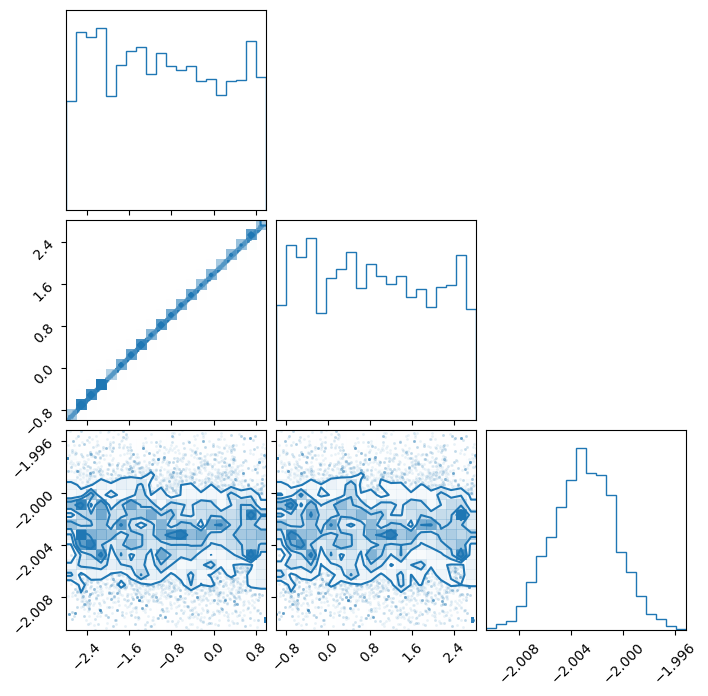

In [20]:
import matplotlib.pyplot as plt
import corner

# Get the results
samples, weights, logl, logp = pmc_sampler.posterior()

# Trace plot for the first 4 parameters
fig = corner.corner(samples, weights=weights, color="C0")
plt.show()